# Cloud Optimization Tests
## Downscaling MUR SST using AWS EC2

See how long it takes to downscale an ultra-high resolution SST product when accessing an SST file on AWS S3 ***using dask***. Downscale from 0.01 degree resolution to 1 deg resolution (global coverage).

Uses the MUR Level 4 daily SST ultra high resolution data product, 0.01 degree resolution, s3 location `s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/`.

<br>

**Requirements to run this notebook**
* Have a URS Earthdata login.
* Run in an AWS EC2 instance (minimum without dask chuncking is a t2.xlarge instance).
* Have URS Earthdata login credentials in the `.netrc` file on the home directory:
```
machine urs.earthdata.nasa.gov
    login <Earthdata username>
    password <Earthdata password>
```

<br>

**Current Status**
* Seems like a minimum of a t2.xlarge instance (8 GB RAM) is required.
* ***Garbage collection and variable deletion is essential. EC2 instance runs out of RAM otherwise.***

<br>

**To do**
* Try to load file with xarray using the `chunks` argument.

In [14]:
import gc
import os
import time

import s3fs
import requests

import xarray as xr
import h5py
import numpy as np
import pandas as pd

import dask
import dask.array as da
from dask.distributed import Client, LocalCluster, progress
from dask import delayed

import matplotlib.pyplot as plt
%matplotlib inline

## Function to set up an s3fs session for Direct Access 
If the following function fails, verify that the following is in the .netrc file in your home directory:
```
machine urs.earthdata.nasa.gov
    login <Earthdata username>
    password <Earthdata password>
```
where the `<Earthdata username>` and `<Earthdata password>` are your login credentials.

In [12]:
def init_S3FileSystem():
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it 
    to obtain a temporary AWS S3 credential through a podaac service accessable at 
    https://archive.podaac.earthdata.nasa.gov/s3credentials
    
    Return:
    =======
    s3: an AWS S3 filesystem
    """
    import requests, s3fs
    creds = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=creds['accessKeyId'],
                           secret=creds['secretAccessKey'], 
                           token=creds['sessionToken'],
                           client_kwargs={'region_name':'us-west-2'})
    return s3

## Functions to load and downscale MUR SST files

In [64]:
def downscale_xr_s3(fs_s3, filepath_s3, output_dir, chunks=None):
    """
    Open and downscale SST's from 1 km to 100 km from a MUR 1 km file on an S3 bucket. fs_s3 is the 
    S3 file system and filepath_s3 is the MUR filepath on S3. output_dir is the directory to save 
    the downscaled data file in.
    """
    
    print('Opening ', filepath_s3)
    s3_file_obj = fs_s3.open(filepath_s3, mode='rb')
    sstdata = xr.open_dataset(s3_file_obj, chunks=chunks)
    
    def downscale_mursst(sst):
        """
        This function takes MUR SST 1km data (with dimensions of 17900x36000), reshapes, and 
        computes the mean temperature in 1x1 degree boxes, and then returns the processed 
        SST data (shape 180x360).

        Parameters
        ----------
        sst: 2D array-like of sea surface temperatures.
        """
        sst0 = np.r_[sst[0:1, :], sst]; del sst
        sst = sst0.reshape(180, 100, 360, 100).mean(axis=-1).mean(axis=1); del sst0
        return sst
    
    print("Downscaling.")
    sst_downscaled = downscale_mursst(sstdata['analysed_sst'][0, ...])
    
    # Save downscaled SST to .nc file:
    print("Saving output.")
    ds = xr.Dataset(
        data_vars=dict(
            sst=(["time", "lat", "lon"], np.expand_dims(sst_downscaled, axis=0)) # Add dim for time.
            ),
        coords=dict(
            lon=sstdata['lon'].values[::100], # lons, lats in downscaled res.
            lat=sstdata['lat'].values[::100],
            time=sstdata["time"].values,
            ),
        attrs=dict(
            description="SST downscaled from MUR 1 km file to 100 km resolution.",
            units="K",
            ),
        )
    ds.to_netcdf(output_dir + filepath_s3.split("/")[-1][:-3] + "_downscaled.nc")
    
    sstdata.close()

## Establish S3 Connection and Get MUR File Paths

In [57]:
# Get temporary AWS credentials for access
fs_s3 = init_S3FileSystem()

In [58]:
# File paths of all MUR granules:
s3path = "s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/"
fns = fs_s3.glob(s3path+"*.nc")
print("total granules = ",len(fns))
print("Example filename: ", fns[0])

total granules =  7665
Example filename:  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc


## Control: Downscaling without Dask

In [7]:
if not os.path.isdir("./sst_downscaled"):
    os.mkdir("./sst_downscaled")

In [8]:
%%time
for i in range(10):
    downscale_xr_s3(fs_s3, fns[i], "./sst_downscaled/")

Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv

## Test: Downscaling with Dask

**Setup Dask**

In [65]:
@dask.delayed
def downscale_xr_s3_dd(fs_s3, filepath_s3, output_dir, chunks=None):
    """
    Open and downscale SST's from 1 km to 100 km from a MUR 1 km file on an S3 bucket. fs_s3 is the 
    S3 file system and filepath_s3 is the MUR filepath on S3. output_dir is the directory to save 
    the downscaled data file in.
    """
    
    print('Opening ', filepath_s3)
    s3_file_obj = fs_s3.open(filepath_s3, mode='rb')
    sstdata = xr.open_dataset(s3_file_obj, chunks=chunks)
    
    def downscale_mursst(sst):
        """
        This function takes MUR SST 1km data (with dimensions of 17900x36000), reshapes, and 
        computes the mean temperature in 1x1 degree boxes, and then returns the processed 
        SST data (shape 180x360).

        Parameters
        ----------
        sst: 2D array-like of sea surface temperatures.
        """
        sst0 = np.r_[sst[0:1, :], sst]; del sst
        sst = sst0.reshape(180, 100, 360, 100).mean(axis=-1).mean(axis=1); del sst0
        return sst
    
    print("Downscaling.")
    sst_downscaled = downscale_mursst(sstdata['analysed_sst'][0, ...])
    
    # Save downscaled SST to .nc file:
    print("Saving output.")
    ds = xr.Dataset(
        data_vars=dict(
            sst=(["time", "lat", "lon"], np.expand_dims(sst_downscaled, axis=0)) # Add dim for time.
            ),
        coords=dict(
            lon=sstdata['lon'].values[::100], # lons, lats in downscaled res.
            lat=sstdata['lat'].values[::100],
            time=sstdata["time"].values,
            ),
        attrs=dict(
            description="SST downscaled from MUR 1 km file to 100 km resolution.",
            units="K",
            ),
        )
    ds.to_netcdf(output_dir + filepath_s3.split("/")[-1][:-3] + "_downscaled.nc")
    
    sstdata.close()

In [66]:
# Detect available vCPUs on this machine:
import multiprocessing
n_workers = multiprocessing.cpu_count()
print(n_workers)

4


In [54]:
#client = Client('tcp://127.0.0.1:36921')
client = Client(n_workers=int(n_workers/2), threads_per_worker=1)
client

/home/ec2-user/conda/envs/jupyter/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43595 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43595/status,
Dashboard: http://127.0.0.1:43595/status,Workers: 2
Total threads: 2,Total memory: 15.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36501,Workers: 2
Dashboard: http://127.0.0.1:43595/status,Total threads: 2
Started: Just now,Total memory: 15.61 GiB
Comm: tcp://127.0.0.1:33417,Total threads: 1
Dashboard: http://127.0.0.1:45655/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:42539,


In [67]:
%%time
dscale_tasks = []
chunks = {'time':1, 'lat':int(17999/3), 'lon':int(36000/3)}
for i in range(10):
    dscale_tasks.append(downscale_xr_s3_dd(fs_s3, fns[i], "./sst_downscaled/", chunks=None))
dscale_tasks

CPU times: user 3.17 ms, sys: 0 ns, total: 3.17 ms
Wall time: 2.54 ms


[Delayed('downscale_xr_s3_dd-0cd265e3-d2c5-4250-b378-d2068fc926da'),
 Delayed('downscale_xr_s3_dd-749f68d6-842a-4107-b62c-5ab5e815ee46'),
 Delayed('downscale_xr_s3_dd-a6e6e309-c281-47b6-bd2f-03ea240be57f'),
 Delayed('downscale_xr_s3_dd-b8b3e729-576c-4027-a928-dee22bbc19bf'),
 Delayed('downscale_xr_s3_dd-a512948e-7bb1-4a74-ab45-89732ef00ba8'),
 Delayed('downscale_xr_s3_dd-3d490c0f-c47e-4907-ba48-09f79116cd9c'),
 Delayed('downscale_xr_s3_dd-22a27384-a400-4e69-a2bf-dfe789f6b4b3'),
 Delayed('downscale_xr_s3_dd-66e8af87-71cf-4300-9e51-b23216368cb4'),
 Delayed('downscale_xr_s3_dd-792a4e6a-38e0-4871-8195-372bbc960a59'),
 Delayed('downscale_xr_s3_dd-1c8cf7a9-4772-4612-91f6-d487fc52baba')]

In [68]:
%%time
_ = da.compute(*dscale_tasks)

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.52 GiB -- Worker memory limit: 7.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.60 GiB -- Worker memory limit: 7.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.67 GiB -- Worker memory limit: 7.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

CPU times: user 12.5 s, sys: 1.11 s, total: 13.6 s
Wall time: 2min 47s


In [42]:
fnames_dscaled = [f for f in os.listdir("./sst_downscaled/") if "_downscaled" in f]
fnames_dscaled

['20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020605090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020602090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020604090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020603090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020606090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020608090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020607090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020609090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020610090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc']

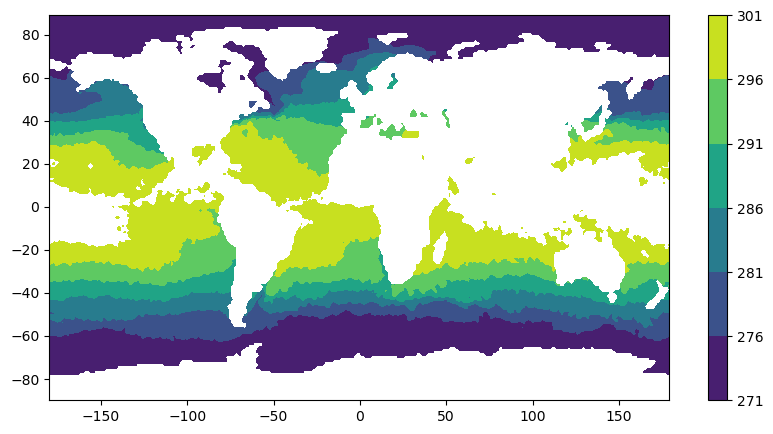

In [52]:
dscaled_test = xr.open_dataset("./sst_downscaled/" + fnames_dscaled[5])
clevs = np.arange(271, 305, 5)

fig = plt.figure(figsize=(10, 5))
ax = plt.axes()
cp = ax.contourf(dscaled_test['lon'], dscaled_test['lat'], dscaled_test['sst'][0, ...], levels=clevs)
fig.colorbar(cp, ax=ax)

dscaled_test.close()

In [39]:
client.close()

Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020606090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020607090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020610090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020604090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020608090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Downscaling.
Saving output.
Opening  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020603090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv

## Summary

* On the t2.xlarge (4 vCPUs, ~16 GiB memory)
>* having 4 workers with 4 threads fails, 
>* having 2 workers with 4 threads succeeds but takes the same amount of time as sequential computation, 
>* having 2 workings with 2 threads completes 32 % faster than sequential computation (from 3 min 52 seconds down to 2 min 38 seconds)
* Where to go from here? Computation time/costs for downscaling 1000 MUR 1 km files on EC2 instances with differing:
>* vCPUs
>* memory per vCPU
>* bandwidth (took 11 seconds to process a file locally on the EC2, vs 27 seconds using S3 access).
>* working with bigger files